<h1>Team Project: Classification modelling for chocolate dataset</h1><hr>

<h3>Description of the dataset </h3>

<h4>Data source</h4><br>
The dataset is from Brady Brelinski, Founding Member of the Manhattan Chocolate Society. The data is also used in a Kaggle competition.<br>

<b>Columns description</b>
<ul>
    <li>Company (Maker-if known): name of the company (string)</li>
    <li>Specific Bean Origin: the geographical origin for the chocolate bar (string).</li>
<li>REF: a value indicating when the review was entered in the database. A higher value indicates more recently entered (integer).</li>
<li>Review Year: the year of the review published (integer).</li>
<li>Cocoa Percentage: cocoa percentage of the chocolate bar (string).</li>
<li>Company Location: the country of the manufacturer (string).</li>
<li>Rating: expert rating for the chocolate bar (float). This is the label to be predicted by the model. It is a number from 1 (lowest quality) to 5 (highest quality).</li>
<li>Bean Type: the type of cocoa bean used (string).</li>
<li>Broad Bean Origin: the broader geographical origin of the cocoa bean (string).</li>
</ul>

<h4>Dataset dimension</h4>
<ul>
<li>Samples (rows): 1500</li>
<li>Attributes (columns): 9 (including the target: rating)</li><ul>

<h3>1. Data Preprocessing</h3>

<h4>1.1 Importing Required Libraries</h4>

In [1]:
#Loading required libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re

# Import Libraries for Modelling
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from imblearn.over_sampling import SMOTE 

# Import Libraries for Map
import json
import folium
from branca.colormap import LinearColormap
#Load the geographically data from world countries json file
geo_data = json.load(open("world-countries.json"))

# Import Libraries for HTML output display
import warnings
from subprocess import check_output
from IPython.core.display import display, HTML
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 4)
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

<h4>1.2 Data Exploration</h4>

In [2]:
#Reading the excel file in a dataframe
df = pd.read_csv("chocolate.csv",error_bad_lines=False,warn_bad_lines=True)

In [3]:
# Descriptive Statics
df.describe()

,REF,Review Date,Rating
count,1500.0000,1500.0000,1500.0000
mean,1036.8813,2012.3260,3.1832
std,554.6938,2.9337,0.4843
min,5.0000,2006.0000,1.0000
25%,572.0000,2010.0000,2.7500
50%,1071.0000,2013.0000,3.2500
75%,1503.0000,2015.0000,3.5000
max,1952.0000,2017.0000,5.0000


In [4]:
# Display dataset top 5 values
df.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Valrhona,Manjari,129,2007,64%,France,4.00,"Criollo, Trinitario",Madagascar
1,Original Beans (Felchlin),"Grand Cru Blend No.1, 5 yr. Anniversary Ed",1442,2014,80%,Switzerland,3.25,Blend,
2,Potomac,Upala w/ nibs,647,2011,70%,U.S.A.,3.50,Matina,Costa Rica
3,Middlebury,"Matagalpa, Cacao Bisiesto",1538,2015,70%,U.S.A.,3.50,,Nicaragua
4,Carlotta Chocolat,Cesar,1888,2016,65%,Colombia,3.50,CCN51,Colombia


In [5]:
# Rename the dataset columns
df.rename(columns = {df.columns[0]:'Company',
                     'Specific Bean Origin\nor Bar Name':'SBO_BN',
                     'Review\nDate':'Review_Date',
                     'Cocoa\nPercent':'Cocoa_Percent',
                     'Company\nLocation':'Company_Location',
                     'Broad Bean\nOrigin':'BBO',
                     'Bean\nType':'Bean_Type'
                    },inplace=True)


In [6]:
#Display rename columns list
df.columns

Index([u'Company', u'SBO_BN', u'REF', u'Review_Date', u'Cocoa_Percent',
       u'Company_Location', u'Rating', u'Bean_Type', u'BBO'],
      dtype='object')

In [7]:
#Iterating over categorical columns to find how many unique values they have.
for column in df[['Company','SBO_BN','Review_Date','Company_Location','Bean_Type','BBO']]:
    print(df[column].value_counts().head(10))
    print("====================================")


Soma             39
Bonnat           23
Fresco           21
Pralus           20
A. Morin         19
Domori           19
Guittard         18
Arete            18
Coppeneur        17
Mast Brothers    17
Name: Company, dtype: int64
Madagascar            42
Peru                  37
Ecuador               37
Dominican Republic    33
Venezuela             18
Sambirano             17
Chuao                 16
Ocumare               15
Papua New Guinea      14
Ghana                 12
Name: SBO_BN, dtype: int64
2015    238
2014    212
2016    180
2012    156
2013    151
2011    137
2009    108
2010     95
2008     76
2007     64
Name: Review_Date, dtype: int64
U.S.A.         632
France         124
Canada         108
U.K.            79
Italy           59
Ecuador         47
Australia       46
Belgium         33
Switzerland     29
Germany         27
Name: Company_Location, dtype: int64
                        750
Trinitario              342
Criollo                 128
Forastero                67
Fora

In [8]:
#Data descriptive statics for all the columns
df.describe(include='all')

,Company,SBO_BN,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,BBO
count,1500,1500,1500.0000,1500.0000,1500,1500,1500.0000,1499,1499
unique,391,893,NaN,NaN,45,57,NaN,36,93
top,Soma,Madagascar,NaN,NaN,70%,U.S.A.,NaN,,Venezuela
freq,39,42,NaN,NaN,568,632,NaN,750,174
mean,NaN,NaN,1036.8813,2012.3260,NaN,NaN,3.1832,NaN,NaN
std,NaN,NaN,554.6938,2.9337,NaN,NaN,0.4843,NaN,NaN
min,NaN,NaN,5.0000,2006.0000,NaN,NaN,1.0000,NaN,NaN
25%,NaN,NaN,572.0000,2010.0000,NaN,NaN,2.7500,NaN,NaN
50%,NaN,NaN,1071.0000,2013.0000,NaN,NaN,3.2500,NaN,NaN
75%,NaN,NaN,1503.0000,2015.0000,NaN,NaN,3.5000,NaN,NaN


<h4>1.3 Data Cleaning & Visualizations</h4>

###### 1.3.1 Removing Percentage from Cocoa_Percent

In [9]:
# Function of remove % from Cocoa Percent column and return float value
def remove_percentage(l):
    temp = l.split('%')
    return np.float32(temp[0])

# Apply the remove percentage function on Cocoa Percent column
df['Cocoa_Percent']= df['Cocoa_Percent'].apply(lambda l: remove_percentage(l))

# Dislay the top 3 records of dataset
df.Cocoa_Percent.head(3)

0    64.0
1    80.0
2    70.0
Name: Cocoa_Percent, dtype: float64

In [10]:
# Data set informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
Company             1500 non-null object
SBO_BN              1500 non-null object
REF                 1500 non-null int64
Review_Date         1500 non-null int64
Cocoa_Percent       1500 non-null float64
Company_Location    1500 non-null object
Rating              1500 non-null float64
Bean_Type           1499 non-null object
BBO                 1499 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 105.5+ KB


In [11]:
# checking null values
df.isnull().sum()

Company             0
SBO_BN              0
REF                 0
Review_Date         0
Cocoa_Percent       0
Company_Location    0
Rating              0
Bean_Type           1
BBO                 1
dtype: int64

In [12]:
# Display bean Type null values
df[df['Bean_Type'].isnull()]

,Company,SBO_BN,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,BBO
177,Soma,"Three Amigos(Chuao, Wild Bolivia, D.R.)",676,2011,70.0,Canada,4.0,NaN,"Ven, Bolivia, D.R."


In [13]:
# Display bean origin null values
df[df['BBO'].isnull()]

,Company,SBO_BN,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,BBO
750,Mast Brothers,Madagascar,999,2012,72.0,U.S.A.,2.5,Trinitario,NaN


The column of bean type and bean origin country column contain many undefined/ unspecified values.
We convert this values into NAN.

In [14]:
unspecified=df.Bean_Type.values[3]

# convert undefined/unspecified values into nan 
def nan_conversion(n):
    if n == unspecified:
        return np.nan
    else:
        return n

# For all columns which datatypes is object apply the nan_conversion function 
# for convert unspecified values into nan or null values
for col in df.columns:
    if df[col].dtype == 'O':
        df[col]=df[col].apply(lambda n: nan_conversion(n))

In [15]:
# Display null values into dataset after function executation
df.isnull().sum()

Company               0
SBO_BN                0
REF                   0
Review_Date           0
Cocoa_Percent         0
Company_Location      0
Rating                0
Bean_Type           751
BBO                  62
dtype: int64

#####  1.3.2 Cleaning Data of Company Location

In [16]:
# Display Unique value of Company location
df['Company_Location'].unique()

array(['France', 'Switzerland', 'U.S.A.', 'Colombia', 'Argentina',
       'Japan', 'U.K.', 'Canada', 'Scotland', 'Germany', 'Ecuador',
       'Guatemala', 'Mexico', 'Nicaragua', 'Sweden', 'Belgium', 'Italy',
       'St. Lucia', 'Brazil', 'New Zealand', 'Australia', 'Denmark',
       'Lithuania', 'Spain', 'Fiji', 'Austria', 'Madagascar',
       'Costa Rica', 'Hungary', 'Portugal', 'Vietnam', 'Peru', 'Ireland',
       'Venezuela', 'Israel', 'Chile', 'Domincan Republic', 'Netherlands',
       'Bolivia', 'Puerto Rico', 'Suriname', 'Iceland', 'South Africa',
       'Grenada', 'Martinique', 'Amsterdam', 'Czech Republic', 'Honduras',
       'Poland', 'South Korea', 'Russia', 'India', 'Ghana', 'Sao Tome',
       'Philippines', 'Singapore', 'Wales'], dtype=object)

###### Bar Chart of Companies Highest Chocolate Vendors

Text(0.5,1,'Companies with the Highest Chocolate Vendors')

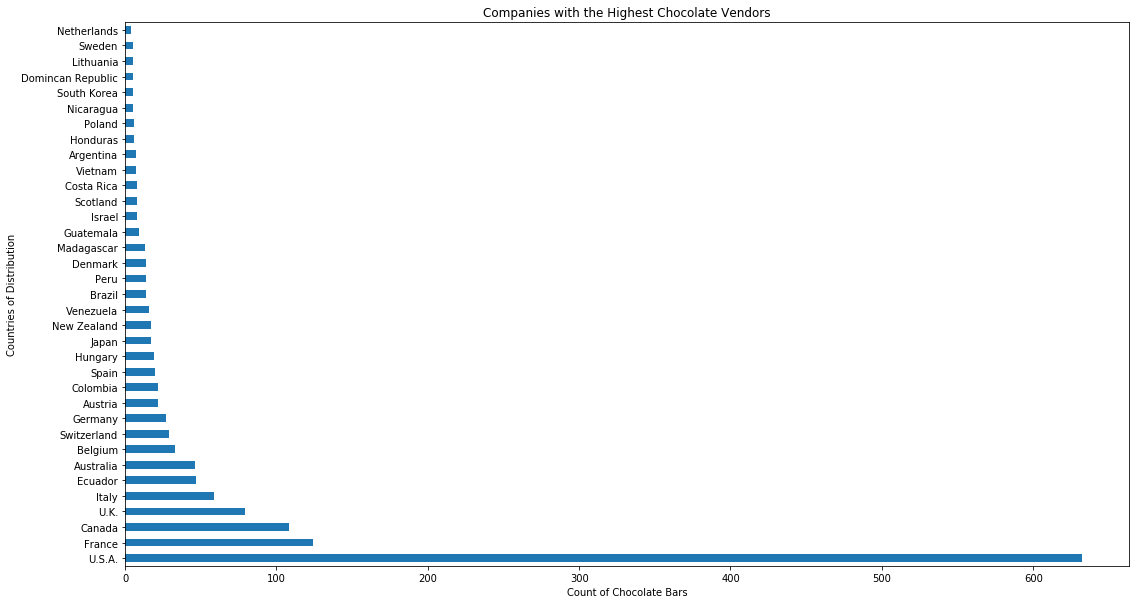

In [17]:
# set the plot figure size
plt.rcParams['figure.figsize'] = (18,10)
# Create count bar plot of comapny location
df['Company_Location'].value_counts().head(35).plot('barh')
# Set the Xlabel on graph
plt.xlabel('Count of Chocolate Bars')
# Set the Ylabel on graph
plt.ylabel('Countries of Distribution')
# Set the title on graph
plt.title("Companies with the Highest Chocolate Vendors")

AS per the company location unique value and shown in graph, There are some company location country name is in short form
and grammatically error. We need to correct that company location name.

###### Rename the Company Location

In [18]:
# Rename the company location 
df['Company_Location'] = df['Company_Location'].str.replace('Domincan Republic', 'Dominican Republic')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Amsterdam', 'Netherlands')\
.str.replace('U.K.', 'England')\
.str.replace('U.S.A', 'American')

# Display the company location unique values
df['Company_Location'].unique()

array(['France', 'Switzerland', 'American.', 'Colombia', 'Argentina',
       'Japan', 'England', 'Canada', 'Scotland', 'Germany', 'Ecuador',
       'Guatemala', 'Mexico', 'Nicaragua', 'Sweden', 'Belgium', 'Italy',
       'St. Lucia', 'Brazil', 'New Zealand', 'Australia', 'Denmark',
       'Lithuania', 'Spain', 'Fiji', 'Austria', 'Madagascar',
       'Costa Rica', 'Hungary', 'Portugal', 'Vietnam', 'Peru', 'Ireland',
       'Venezuela', 'Israel', 'Chile', 'Dominican Republic',
       'Netherlands', 'Bolivia', 'Puerto Rico', 'Suriname', 'Iceland',
       'South Africa', 'Grenada', 'Martinique', 'Czech Republic',
       'Honduras', 'Poland', 'South Korea', 'Russia', 'India', 'Ghana',
       'Sao Tome', 'Philippines', 'Singapore', 'Wales'], dtype=object)

##### 1.3.3  Cleaning Data of Bean Origin or Country of Bean origin

In [19]:
# Display Bean origin unique values
df['BBO'].unique()

array(['Madagascar', nan, 'Costa Rica', 'Nicaragua', 'Colombia',
       'Ecuador', 'Trinidad', 'Venezuela', 'Dominican Republic', 'Peru',
       'Peru, Mad., Dom. Rep.', 'Domincan Republic', 'Jamaica', 'Vietnam',
       'Mexico', 'Honduras', 'Guatemala', 'Sri Lanka', 'Indonesia',
       'Puerto Rico', 'St. Lucia', 'Hawaii', 'Peru, Ecuador', 'Ghana',
       'Brazil', 'Ivory Coast', 'Uganda', 'Samoa', 'Tanzania',
       'Papua New Guinea', 'Togo', 'Bolivia', 'Panama', 'Belize',
       'Vanuatu', 'Fiji', 'Peru, Madagascar', 'Central and S. America',
       'Tobago', 'Sao Tome', 'Trinidad, Tobago', 'Cuba',
       'Ven, Bolivia, D.R.', 'Sao Tome & Principe', 'Carribean',
       'Venezuela, Dom. Rep.', 'Dominican Rep., Bali',
       'Ghana, Panama, Ecuador', 'Grenada', 'Principe',
       'Venezuela, Trinidad', 'Australia', 'South America',
       'Colombia, Ecuador', 'Ecuador, Costa Rica',
       'South America, Africa', 'Malaysia', 'Congo', 'PNG, Vanuatu, Mad',
       'Gre., PNG, Haw., Hait

###### Boxplot, Rating for countries of Bean Origin

Text(0.5,1,'Boxplot, Rating for countries of Bean Origin')

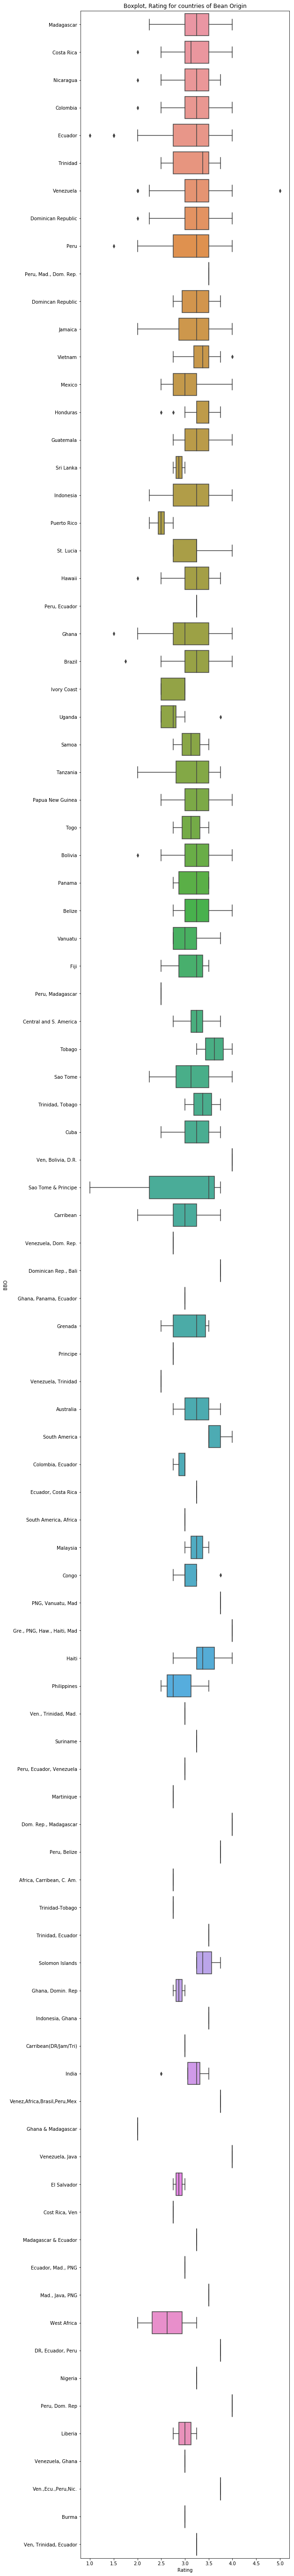

In [20]:
# set the plot figure size
fig, ax = plt.subplots(figsize=[8, 100])
# Create box plot of Bean origin and rating
sns.boxplot(
    data=df,
    y='BBO',
    x='Rating'
)
# Set the title on graph
ax.set_title('Boxplot, Rating for countries of Bean Origin')

As shown in graph and unique values of bean origin, there are some bean origin contains symbols and special characters. Also, name of bean origin country name is in short form and some of grammatically error.
We need to remove that symbols and special characters and replace with white space or comma.
We need to correct the origin country name.

###### Remove Symbols or Special Characters from Bean origin

In [21]:
# Function remove the special characters and symbols from bean origin and return clean value of bean origin country.
def bean_origin_symbol_clean(bbo):
    # Create the list of symbol with it corresponding replace value
    bean_origin_symbol_clean_list = [
        [' and', ', '],
        [' &', ', '], 
        ['-', ', '],
        ['\(', ', '], 
        ['\)', ''],
        ['/', ', '],
        [',  ', ', '],
        [', ', ',']
    ]
    
    # Reccuresive replace the sybmol or characters and return the clean value of bean origin country value.
    for b, o in bean_origin_symbol_clean_list:
        bbo = re.sub(b, o, bbo)
    return bbo

In [22]:
# Convert the column in String data types
df['BBO'] = df['BBO'].astype("|S")
# Apply the function of symbol and special characters removal
df['BBO'] = df['BBO'].str.replace('.', '').apply(bean_origin_symbol_clean)
# Display the unique values of bean origin
df['BBO'].unique()

array(['Madagascar', 'nan', 'Costa Rica', 'Nicaragua', 'Colombia',
       'Ecuador', 'Trinidad', 'Venezuela', 'Dominican Republic', 'Peru',
       'Peru,Mad,Dom Rep', 'Domincan Republic', 'Jamaica', 'Vietnam',
       'Mexico', 'Honduras', 'Guatemala', 'Sri Lanka', 'Indonesia',
       'Puerto Rico', 'St Lucia', 'Hawaii', 'Peru,Ecuador', 'Ghana',
       'Brazil', 'Ivory Coast', 'Uganda', 'Samoa', 'Tanzania',
       'Papua New Guinea', 'Togo', 'Bolivia', 'Panama', 'Belize',
       'Vanuatu', 'Fiji', 'Peru,Madagascar', 'Central,S America',
       'Tobago', 'Sao Tome', 'Trinidad,Tobago', 'Cuba', 'Ven,Bolivia,DR',
       'Sao Tome,Principe', 'Carribean', 'Venezuela,Dom Rep',
       'Dominican Rep,Bali', 'Ghana,Panama,Ecuador', 'Grenada',
       'Principe', 'Venezuela,Trinidad', 'Australia', 'South America',
       'Colombia,Ecuador', 'Ecuador,Costa Rica', 'South America,Africa',
       'Malaysia', 'Congo', 'PNG,Vanuatu,Mad', 'Gre,PNG,Haw,Haiti,Mad',
       'Haiti', 'Philippines', 'Ven,Trinid

###### Rename the bean origin value

In [23]:
# Function correct the bean origin name and return clean value of bean origin country.
def bean_origin_name_clean(bbo):
    # Create the list of error in name of bean origin with it corresponding replace value
    bean_origin_name_clean_list = [
        ['Bali',',Bali'],
        ['C Am', 'Central America'],
        ['Cost Rica', 'Costa Rica'],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Ecu,', 'Ecuador,'],
        ['Gre,', 'Grenada,'],
        ['Haw,', 'Hawaii,'],
        ['Jam,', 'Jamaica,'],
        ['Mad,', 'Madagascar,'],
        ['Mad$', 'Madagascar'],
        ['Mex$', 'Mexico'],
        ['Nic$', 'Nicaragua'],       
        ['PNG,', 'Papua New Guinea,'],
        ['PNG$', 'Papua New Guinea'],
        ['S America', 'South America'],
        ['Ven,|Venez,', 'Venezuela,'],
        ['Ven$', 'Venezuela'],
        ['Tri$', 'Trinidad']
        
    ]
    
    # Reccuresive replace the bean origin name and return the clean value of bean origin country value.
    for b, o in bean_origin_name_clean_list:
        bbo = re.sub(b, o, bbo)
    return bbo

In [24]:
# Apply the function of bean origin name replacement with correct one.
df['BBO'] = df['BBO'].apply(bean_origin_name_clean)
# Display the unique values of bean origin
df['BBO'].unique()

array(['Madagascar', 'nan', 'Costa Rica', 'Nicaragua', 'Colombia',
       'Ecuador', 'Trinidad', 'Venezuela', 'Dominican Republic', 'Peru',
       'Peru,Madagascar,Dominican Republic', 'Jamaica', 'Vietnam',
       'Mexico', 'Honduras', 'Guatemala', 'Sri Lanka', 'Indonesia',
       'Puerto Rico', 'St Lucia', 'Hawaii', 'Peru,Ecuador', 'Ghana',
       'Brazil', 'Ivory Coast', 'Uganda', 'Samoa', 'Tanzania',
       'Papua New Guinea', 'Togo', 'Bolivia', 'Panama', 'Belize',
       'Vanuatu', 'Fiji', 'Peru,Madagascar', 'Central,South America',
       'Tobago', 'Sao Tome', 'Trinidad,Tobago', 'Cuba',
       'Venezuela,Bolivia,Dominican Republic', 'Sao Tome,Principe',
       'Carribean', 'Venezuela,Dominican Republic',
       'Dominican Republic,Bali', 'Ghana,Panama,Ecuador', 'Grenada',
       'Principe', 'Venezuela,Trinidad', 'Australia', 'South America',
       'Colombia,Ecuador', 'Ecuador,Costa Rica', 'South America,Africa',
       'Malaysia', 'Congo', 'Papua New Guinea,Vanuatu,Madagascar',
 

##### 1.3.4 Cleaning Rating Values

In [25]:
# Display the count value of ratings
df.Rating.value_counts()

3.50    320
3.00    285
3.25    251
2.75    210
3.75    181
2.50    115
4.00     82
2.00     28
2.25     12
1.50      9
1.00      4
5.00      2
1.75      1
Name: Rating, dtype: int64

###### Count of Chocolate Bar Ratings

Text(0.5,1,'Number of Users that Rated Chocolate Bars')

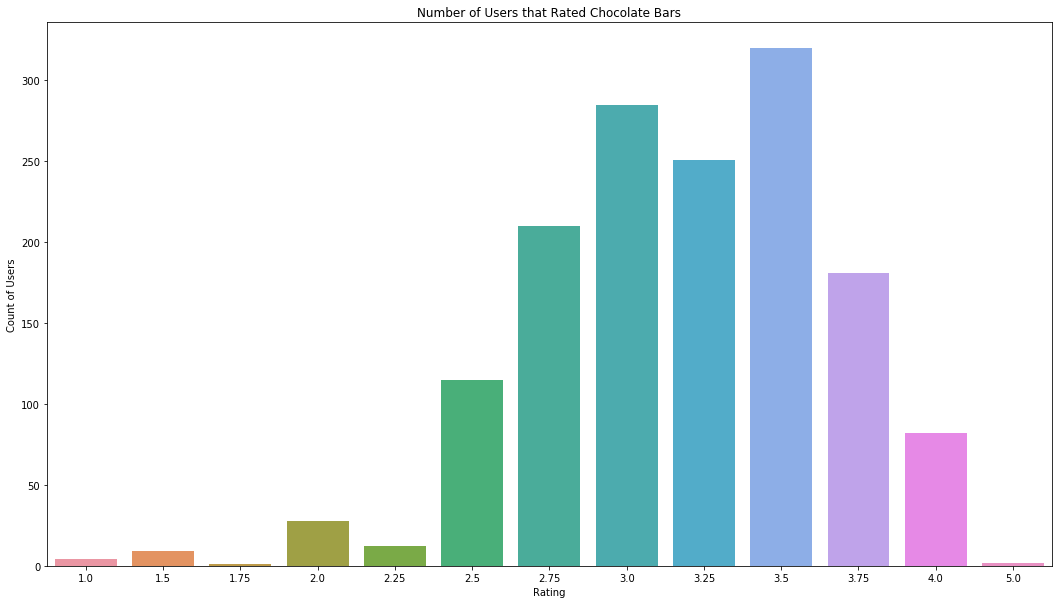

In [26]:
# Seaborn count plot for Rating column
sns.countplot(x='Rating', data=df)
# Set the Xlabel on graph
plt.xlabel('Rating')
# Set the Ylabel on graph
plt.ylabel('Count of Users')
# Set the title on graph
plt.title('Number of Users that Rated Chocolate Bars')

###### Rating value convert into Floor Value

In [27]:
# Convert the rating value into Floor Value of that rating value
def rating_round_convert(num, precision=0):
    # multiply the precision with 10
    multiplication = 10 ** precision
    # return the convert int value of rating
    return int(num * multiplication) / multiplication

In [28]:
# Apply the function of rating round convert
df['Rating'] = df['Rating'].apply(rating_round_convert)
# Changed the data type from int to float
df['Rating'] = df['Rating'].astype(float)

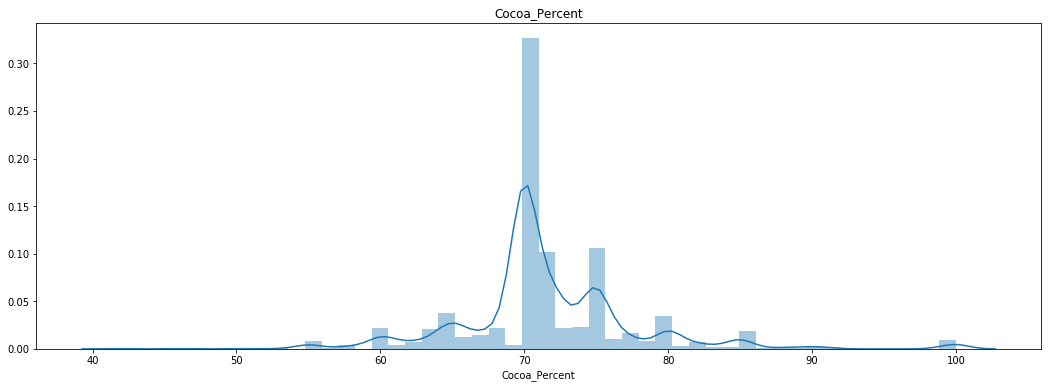

In [29]:
# set the plot figure size
plt.rcParams['figure.figsize'] = (18,6)
# Create dist plot of cocoa percent
ax = sns.distplot(df['Cocoa_Percent'])
# Set the title on graph
plt.title("Cocoa_Percent")
# Display dist plot
plt.show()

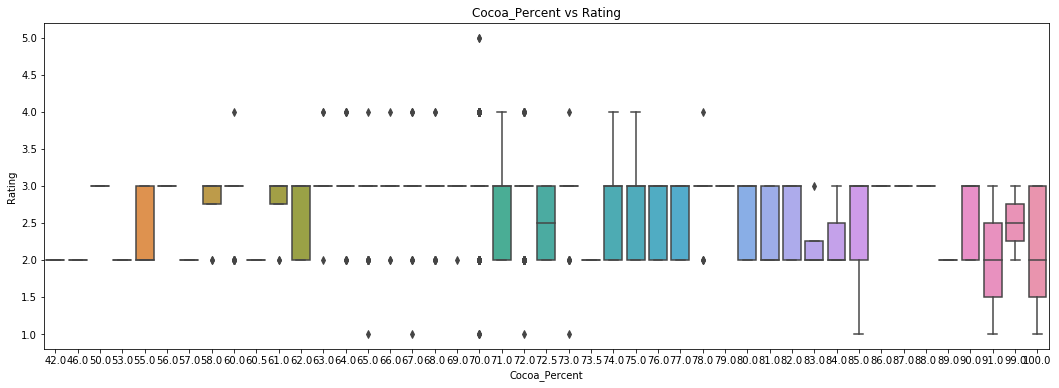

In [30]:
# set the plot figure size
plt.rcParams['figure.figsize'] = (18,6)
# Create box plot of Cocoa_Percent and Rating
ax = sns.boxplot(x='Cocoa_Percent',y='Rating', data=df)
# Set the title on graph
plt.title("Cocoa_Percent vs Rating")
# Display Box plot
plt.show()

#### Creating Custom Column for blends

In [31]:
# Create the new column is_blend based on specific bean origin and bean origin country contains the multiple value or single value.
df['is_blend'] = np.where(np.logical_or(np.logical_or(df['SBO_BN'].str.lower().str.contains(',|(blend)|;'),df['BBO'].str.len() == 1),
        df['BBO'].str.lower().str.contains(',')), 1 , 0)

##### 1.3.5  Drop Column Specific Bean origin and REF

The specific bean origin is largly duplicate with Bean origin and the number of referece when highest number of corresponds entry made on that date.
This Two colum is not useful for modelling for that we are drop these two columns.

In [32]:
# Drop the specific bean origin and REF columns
df.drop(['SBO_BN', 'REF'], axis = 1, inplace = True)

##### 1.3.6  Cleaning Compny Name Remove Special characters

In [33]:
# Display the company unique values
df['Company'].unique()

array(['Valrhona', 'Original Beans (Felchlin)', 'Potomac', 'Middlebury',
       'Carlotta Chocolat', 'Salgado', 'Cacao Store', 'Kaoka (Cemoi)',
       'Woodblock', 'Dormouse', 'Soma', 'Mast Brothers',
       'Bittersweet Origins', 'Chocolate Tree, The', 'Mayacama',
       'Fruition', 'Mars', 'Fresco', 'Tablette (aka Vanillabeans)',
       'Compania de Chocolate (Salgado)', 'Pralus', 'Coppeneur',
       'Chchukululu (Tulicorp)', 'Black Mountain', 'Bonnat', 'hexx',
       'Askinosie', 'Danta', 'Quetzalli (Wolter)', "K'ul",
       'Chocolats Privilege', 'Momotombo',
       'Republica del Cacao (aka Confecta)', 'Tejas',
       'Svenska Kakaobolaget', 'Benoit Nihant', 'Amedei',
       'Chloe Chocolat', 'Montecristi', 'Domori', 'Guido Castagna',
       'Madre', 'Emerald Estate', 'Starchild', 'Lonohana', 'Ah Cacao',
       'TCHO', 'Violet Sky', 'Mission', 'French Broad', 'Kto', 'Theo',
       'Kyya', 'Letterpress', 'Ocho', 'Sirene', 'Palette de Bine',
       'Arete', 'Dandelion', 'Georgia Ram

As per unique values of Chocolate company name, there are contains symbols and special characters. 
We need to remove that symbols and special characters and replace with white space.

In [34]:
# Function remove the special characters and symbols from company name and return clean value of company name
def company_name_clean(cname):
    # Create the list of symbol with it corresponding replace value
    company_name_clean_list = [         
       
        ['\'',''],
        ['\(',''],
        ['\)',''],
        [',',''],
        ['"','\''],
        ['&',''],
        ['-',''],
        [' and ',' '],
        ['  ',''],
        ['Na�ve','Naive']

    ]
    
    # Reccuresive replace the sybmol or characters and return the clean value of company name
    for b, o in company_name_clean_list:
        cname = re.sub(b, o, cname)
    return cname

In [35]:
# Apply the function of symbol and special characters removal
df['Company'] = df['Company'].str.replace('.', '').apply(company_name_clean)
# Display the unique values of company name
df['Company'].unique()

array(['Valrhona', 'Original Beans Felchlin', 'Potomac', 'Middlebury',
       'Carlotta Chocolat', 'Salgado', 'Cacao Store', 'Kaoka Cemoi',
       'Woodblock', 'Dormouse', 'Soma', 'Mast Brothers',
       'Bittersweet Origins', 'Chocolate Tree The', 'Mayacama',
       'Fruition', 'Mars', 'Fresco', 'Tablette aka Vanillabeans',
       'Compania de Chocolate Salgado', 'Pralus', 'Coppeneur',
       'Chchukululu Tulicorp', 'Black Mountain', 'Bonnat', 'hexx',
       'Askinosie', 'Danta', 'Quetzalli Wolter', 'Kul',
       'Chocolats Privilege', 'Momotombo',
       'Republica del Cacao aka Confecta', 'Tejas',
       'Svenska Kakaobolaget', 'Benoit Nihant', 'Amedei',
       'Chloe Chocolat', 'Montecristi', 'Domori', 'Guido Castagna',
       'Madre', 'Emerald Estate', 'Starchild', 'Lonohana', 'Ah Cacao',
       'TCHO', 'Violet Sky', 'Mission', 'French Broad', 'Kto', 'Theo',
       'Kyya', 'Letterpress', 'Ocho', 'Sirene', 'Palette de Bine',
       'Arete', 'Dandelion', 'Georgia Ramon', 'Malmo', 'B

Text(0.5,1,'Flow from origin to Company location, mean rating')

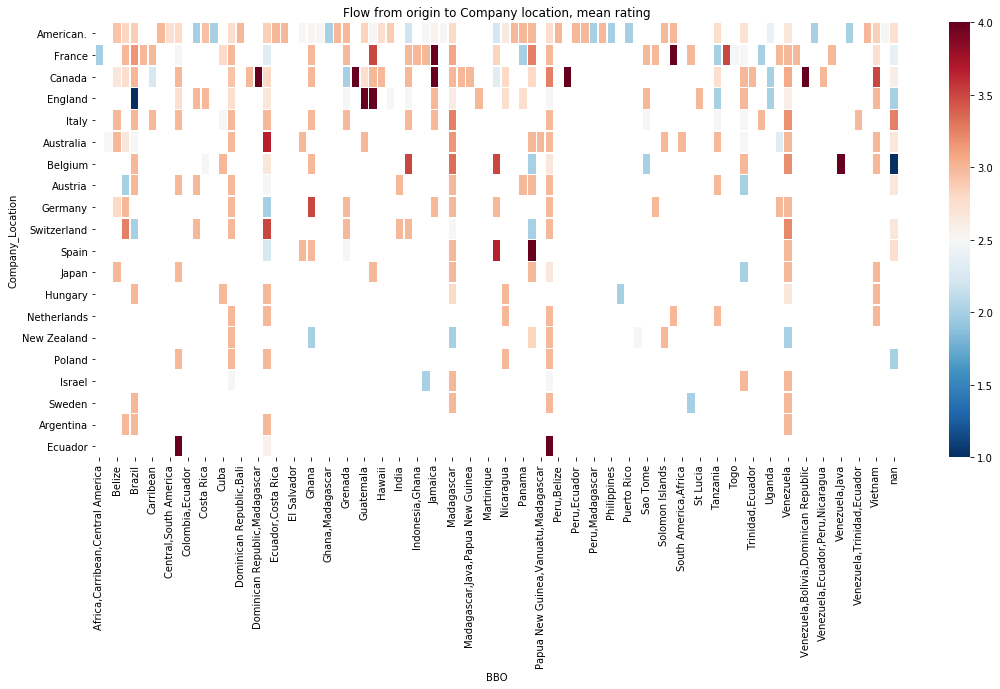

In [36]:
# Select the columns for heat map flow
flow = pd.crosstab(
    df['Company_Location'],
    df['BBO'],
    df['Rating'], aggfunc='mean'
)
# Skip row with row label
flow['tot'] = flow.sum(axis=1)
# Sort the value of row label
flow = flow.sort_values('tot', ascending=False)
flow = flow.drop('tot', axis=1)
# set the plot figure size
fig, ax = plt.subplots(figsize=[18,8])
# Display the seaborn heat map of company location, bean origin and rating
sns.heatmap(flow.head(20), cmap='RdBu_r', linewidths=.5)
# Set the title on graph
ax.set_title('Flow from origin to Company location, mean rating')

<h3>2. Data Modelling</h3>

After the data-processing and exploring the dataset, it was decided to treat this problem as classification issue. The reasons for that decision are listed below:
<ul>
    <li>The target varibale has 13 unique values, which can not be exactly considered as continuous values. Therefore, applying regression on the dataset can result in the target variable sometimes having values which are not in the list.</li>
    <li>It is better to consider these values as classes and treat this problem as classification problem as the values predcicted by the classification model will adhere to the classes in the target variable.</li>
    <li>classes of target variable can be clubbed with each other to reduce the number of categories, which can help in improving the performance of the classification model.</li>
 </ul>
 <br>
 Following algorithms were selected to create classification models.
 <ol>
    <li><b>Random Forest:</b>This algorithm is an ensemble learning method. Uses bootstrap aggregating or bagging for tree learners.</li>
    <li><b>Logistic Regression:</b>This algorithm works well for multiclass target variable such in our case.</li>
    <li><b>K nearest neighbors:</b>As the data in our dataset is biased and instances having certain origin or coc tend to have higher ratings.</li>

<h4>2.1 Label Encoding</h4>

In the dataset, most of the attributes are categorical, including the target variable. However, the models do not accept cateforical data. Therefore, these attributes need to be encoded with numbers so that they can be fed to the model. <br><br>
One-Hot encoding method of pandas library is used to encode the categorical attributes as shown below.

In [37]:
#Applying one-hot encoding to categorical columns of the dataframe
cat_cols=['Company','Review_Date','Company_Location','Bean_Type','BBO'] #selecting categorical variables
dummies=pd.get_dummies(df,columns=cat_cols,drop_first=True) #one-hot encoding
dummies.columns#checking the resulted columns

Index([u'Cocoa_Percent', u'Rating', u'is_blend', u'Company_AMMA',
       u'Company_Acalli', u'Company_Adi', u'Company_Aequare Gianduja',
       u'Company_Ah Cacao', u'Company_Akessons Pralus',
       u'Company_Alain Ducasse',
       ...
       u'BBO_Venezuela,Dominican Republic',
       u'BBO_Venezuela,Ecuador,Peru,Nicaragua', u'BBO_Venezuela,Ghana',
       u'BBO_Venezuela,Java', u'BBO_Venezuela,Trinidad',
       u'BBO_Venezuela,Trinidad,Ecuador', u'BBO_Venezuela,Trinidad,Madagascar',
       u'BBO_Vietnam', u'BBO_West Africa', u'BBO_nan'],
      dtype='object', length=582)

<h4>2.2 Oversampling & Train-Test Split</h4>

The dataset is biased. As the target attribute has more values for some classes and very less or no values for others. Therefore, SMOTE algorithm is used to resample the data and make sure the class distribution in target variable is fair.

In [38]:
#There are only two instances with rating 5, so SMOTE will not work properly if those values are present,
#Therefore, clubbing those instances with instances which have rating 4.
dummies['Rating'].replace({5:4},inplace=True)


X = dummies.drop('Rating',axis=1) #Feature Variables                                                       
y = dummies['Rating']  #Target Variable

sm = SMOTE(random_state=5687, ratio = 1.0) #Creating SMOTE variables
X_SMOTE, y_SMOTE = sm.fit_sample(X, y)#Resampling the dataset


X_train,X_test,y_train,y_test=train_test_split(X_SMOTE,y_SMOTE,test_size=0.20,random_state=0) #Splitting data in train-test


pred_results = pd.DataFrame(y_test,columns=['y_test'])

C:\Users\bajan\.conda\envs\py27\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


<h4>2.4 Random Forest Classification</h4>

Random Forest classifier object with some hyperparameters is created in this section, to observe the behaviour of the model. In next section a paramter grid is defined to check how model performs with different sets of hyper-parameters.

In [39]:
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

rfc.fit(X_train, y_train)

rfc_predict = rfc.predict(X_test)

pred_results['rfc_no_grid']=rfc_predict

rfc_cv_score = cross_val_score(rfc, X,y, cv=5) #calc AUC scores

accuracy = accuracy_score(y_test, rfc_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, rfc.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))



print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", rfc_cv_score.mean())

Test Accuracy: 79.41%
Training Accuracy: 98.32%
=== Confusion Matrix ===
[[202   0   2   0]
 [  1  15  51   0]
 [  2  18 184   9]
 [  0   2  19   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       204
         2.0       0.43      0.22      0.29        67
         3.0       0.72      0.86      0.78       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.79      0.79      0.79       505
   macro avg       0.53      0.52      0.52       505
weighted avg       0.76      0.79      0.77       505



=== Cross Validation Scores ===
[0.66445183 0.68438538 0.64       0.64       0.68791946]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6633513344779148)


In [40]:
#Listing Important Features.
tmp = pd.DataFrame({'Feature': X, 'Feature importance': rfc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
tmp[0:20]

,Feature,Feature importance
580,"(B, B, O, _, n, a, n)",0.1119
0,"(C, o, c, o, a, _, P, e, r, c, e, n, t)",0.0911
405,"(C, o, m, p, a, n, y, _, L, o, c, a, t, i, o, ...",0.0370
391,"(R, e, v, i, e, w, _, D, a, t, e, _, 2, 0, 0, 7)",0.0358
509,"(B, B, O, _, E, c, u, a, d, o, r)",0.0320
1,"(i, s, _, b, l, e, n, d)",0.0243
118,"(C, o, m, p, a, n, y, _, D, o, l, f, i, n, , ...",0.0235
541,"(B, B, O, _, P, e, r, u)",0.0202
396,"(R, e, v, i, e, w, _, D, a, t, e, _, 2, 0, 1, 2)",0.0201
444,"(C, o, m, p, a, n, y, _, L, o, c, a, t, i, o, ...",0.0200


<hr>
As can be seen from the output, the classifier is overfitting with a huge margin of accuracy between training and test dataset. Also, the mean cross validation score for 5-fold cv amounts to 0.66, which is signifies that the model did not perform well. The same can be verified from the classification report.
<hr>

<h4>2.5 Random Forest Classification with RandomizedSearchCV</h4>

Using Random Forest algorithm without tuning hyperparameters resulted in overfitting. Therefore,in this module, a random parameter grid is built which can iterate multiple times and find out the best parameters for the model and possibly reduce overfitting.

In [41]:
#Importing required library
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5,10,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [42]:
#Creating Classifier Variable
rfc2 = RandomForestClassifier()

#Defining the parameters of randomizedsearchcv
rf_random = RandomizedSearchCV(estimator = rfc2, param_distributions = random_grid, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1) 

rf_random.fit(X_train,y_train)# fitting the training data to model

rfc_predict = rf_random.predict(X_test) #making predictions

pred_results['rfc_grid']=rfc_predict

rfc_cv_score = cross_val_score(rf_random, X,y, cv=5) #calc AUC scores

accuracy = accuracy_score(y_test, rfc_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, rfc.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))



print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", rfc_cv_score.mean())

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.4s finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished


Test Accuracy: 82.18%
Training Accuracy: 98.32%
=== Confusion Matrix ===
[[204   0   0   0]
 [  2   0  65   0]
 [  2   0 211   0]
 [  0   0  21   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99       204
         2.0       0.00      0.00      0.00        67
         3.0       0.71      0.99      0.83       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.82      0.82      0.82       505
   macro avg       0.42      0.50      0.45       505
weighted avg       0.70      0.82      0.75       505



=== Cross Validation Scores ===
[0.6910299  0.69435216 0.68666667 0.68666667 0.69127517]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6899981121838465)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<hr> As can be seen from the output, this model achieved higher accuracy for test data. However, the overfitting issue is still there and cv score is also not improved by much.
<hr>

<h4>2.6 Logistic Regression</h4>

In this section logistic regression classifier is applied to the data as it tends to handle multi-class classification fairly well compared to random forest.

In [43]:
#Creating Classifier Variable
logreg = LogisticRegression(random_state = 0)

# fitting the training data to model
logreg.fit(X_train, y_train)

#Making Predictions
logreg_predict = logreg.predict(X_test)

pred_results['logreg']=logreg_predict

accuracy = accuracy_score(y_test, logreg_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, logreg.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

logreg_cv_score = cross_val_score(logreg, X, y, cv=5) #calc cv scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, logreg_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, logreg_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(logreg_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", logreg_cv_score.mean())


Test Accuracy: 80.79%
Training Accuracy: 85.58%
=== Confusion Matrix ===
[[204   0   0   0]
 [  4   8  55   0]
 [  4  12 196   1]
 [  0   1  20   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.96      1.00      0.98       204
         2.0       0.38      0.12      0.18        67
         3.0       0.72      0.92      0.81       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.81      0.81      0.81       505
   macro avg       0.52      0.51      0.49       505
weighted avg       0.74      0.81      0.76       505



=== Cross Validation Scores ===
[0.6744186  0.68106312 0.7        0.67333333 0.68791946]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6833469047990665)


<hr> This model achieved the accuracy of 80.79% for test data and it reduced the overfitting compared to the random forest model. However, the cross-validation score for 5-fold cv is still at 0.68, which is quite average.<hr>

<h4>2.7 KNN classification (neoghbors=6)</h4>

This algorithm is one of the simplest classification algorithms. For a given instance it takes vote from n neighbours, which is defined by user and makes predictions based on that. This algorithm is applied with different values of neighbours and the predictions values are stored in a dataframe.

In [44]:
#Creating classifier variable & providing hyperparameter values
knn=KNeighborsClassifier(n_neighbors = 6, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)# fitting the training data to model

knn_predict = knn.predict(X_test)#Making predictions

pred_results['KNN_6']=knn_predict

accuracy = accuracy_score(y_test, knn_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, knn.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

knn_cv_score = cross_val_score(knn, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, knn_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, knn_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", knn_cv_score.mean())


Test Accuracy: 75.64%
Training Accuracy: 80.53%
=== Confusion Matrix ===
[[204   0   0   0]
 [ 18  15  34   0]
 [ 34  16 163   0]
 [  1   2  18   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.79      1.00      0.89       204
         2.0       0.45      0.22      0.30        67
         3.0       0.76      0.77      0.76       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.76      0.76      0.76       505
   macro avg       0.50      0.50      0.49       505
weighted avg       0.70      0.76      0.72       505



=== Cross Validation Scores ===
[0.66445183 0.64119601 0.66666667 0.64333333 0.67449664]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6580288969653727)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This model performed average in terms of accuracy and the cross validation score is also low compared to previous models. No predictions for rating 4.

<h4>2.7 KNN classification (neoghbors=7)</h4>

In [45]:
#Creating classifier variable & providing hyperparameter values
knn=KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)# fitting the training data to model

knn_predict = knn.predict(X_test)#Making predictions

pred_results['KNN_6']=knn_predict

accuracy = accuracy_score(y_test, knn_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, knn.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

knn_cv_score = cross_val_score(knn, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, knn_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, knn_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", knn_cv_score.mean())


Test Accuracy: 75.05%
Training Accuracy: 79.19%
=== Confusion Matrix ===
[[204   0   0   0]
 [ 20   8  39   0]
 [ 36  10 167   0]
 [  3   1  17   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.78      1.00      0.87       204
         2.0       0.42      0.12      0.19        67
         3.0       0.75      0.78      0.77       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.75      0.75      0.75       505
   macro avg       0.49      0.48      0.46       505
weighted avg       0.69      0.75      0.70       505



=== Cross Validation Scores ===
[0.68770764 0.65780731 0.65       0.65333333 0.70134228]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6700381130757281)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy increased compared to previous knn model. However, cv score decreased. No predictions for rating 4. Let's increase the number of neighbours.

<h4>2.8 KNN classification (neoghbors=8)</h4>

In [46]:
#Creating classifier variable & providing hyperparameter values
knn=KNeighborsClassifier(n_neighbors = 8, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)# fitting the training data to model

knn_predict = knn.predict(X_test)#Making predictions

pred_results['KNN_8']=knn_predict

accuracy = accuracy_score(y_test, knn_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, knn.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

knn_cv_score = cross_val_score(knn, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, knn_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, knn_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", knn_cv_score.mean())


Test Accuracy: 74.85%
Training Accuracy: 77.70%
=== Confusion Matrix ===
[[204   0   0   0]
 [ 20  11  36   0]
 [ 39  11 163   0]
 [  4   2  15   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.76      1.00      0.87       204
         2.0       0.46      0.16      0.24        67
         3.0       0.76      0.77      0.76       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.75      0.75      0.75       505
   macro avg       0.50      0.48      0.47       505
weighted avg       0.69      0.75      0.70       505



=== Cross Validation Scores ===
[0.64451827 0.64784053 0.64       0.66333333 0.67114094]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6533666153834721)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Overfitting reduced. However, the cv score didn't improve and accuracy decreased by a percent. Also, No predictions for rating 4.

<h4>2.9 KNN classification (neoghbors=9)</h4>

In [47]:
#Creating classifier variable & providing hyperparameter values
knn=KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)# fitting the training data to model

knn_predict = knn.predict(X_test)#Making predictions

pred_results['KNN_9']=knn_predict

accuracy = accuracy_score(y_test, knn_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, knn.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

knn_cv_score = cross_val_score(knn, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, knn_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, knn_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", knn_cv_score.mean())


Test Accuracy: 72.87%
Training Accuracy: 77.35%
=== Confusion Matrix ===
[[204   0   0   0]
 [ 20   7  40   0]
 [ 46  10 157   0]
 [  7   1  13   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.74      1.00      0.85       204
         2.0       0.39      0.10      0.16        67
         3.0       0.75      0.74      0.74       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.73      0.73      0.73       505
   macro avg       0.47      0.46      0.44       505
weighted avg       0.66      0.73      0.68       505



=== Cross Validation Scores ===
[0.67109635 0.65116279 0.68333333 0.66666667 0.67114094]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6686800151619879)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy decreased, cv didn't improve much. No predictions for rating 4.

<h4>2.10 KNN classification (neoghbors=10)</h4>

In [48]:
#Creating classifier variable & providing hyperparameter values
knn=KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)# fitting the training data to model

knn_predict = knn.predict(X_test)#Making predictions

pred_results['KNN_10']=knn_predict

accuracy = accuracy_score(y_test, knn_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, knn.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

knn_cv_score = cross_val_score(knn, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, knn_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, knn_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score - Random Forest: ", knn_cv_score.mean())


Test Accuracy: 72.08%
Training Accuracy: 76.46%
=== Confusion Matrix ===
[[204   0   0   0]
 [ 21   7  39   0]
 [ 48  12 153   0]
 [  7   0  14   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.73      1.00      0.84       204
         2.0       0.37      0.10      0.16        67
         3.0       0.74      0.72      0.73       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.72      0.72      0.72       505
   macro avg       0.46      0.46      0.43       505
weighted avg       0.66      0.72      0.67       505



=== Cross Validation Scores ===
[0.67774086 0.65780731 0.68       0.66666667 0.69127517]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score - Random Forest: ', 0.6746980014418753)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Similar results as above. No predictions for rating 4. Let's try with less number of neighbours and see if predictions are made for rating 4.

<h4>2.11 KNN classification (neighbors=3)</h4>

In [49]:
#Creating classifier variable & providing hyperparameter values
knn=KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)# fitting the training data to model

knn_predict = knn.predict(X_test)#Making predictions

pred_results['KNN_3']=knn_predict

accuracy = accuracy_score(y_test, knn_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, knn.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

knn_cv_score = cross_val_score(knn, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, knn_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, knn_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", knn_cv_score.mean())


Test Accuracy: 73.47%
Training Accuracy: 85.73%
=== Confusion Matrix ===
[[204   0   0   0]
 [ 12  12  43   0]
 [ 24  31 155   3]
 [  0   1  20   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.85      1.00      0.92       204
         2.0       0.27      0.18      0.22        67
         3.0       0.71      0.73      0.72       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.73      0.73      0.73       505
   macro avg       0.46      0.48      0.46       505
weighted avg       0.68      0.73      0.70       505



=== Cross Validation Scores ===
[0.62458472 0.64119601 0.64666667 0.59333333 0.67114094]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.635384334098865)


The predictions were made for rating 4. However, with 3 neighbours, overfitting issue occurred, not much change in cv for better. Let's try with higher number of neighbours say 20.

<h4>2.12 KNN classification (neighbors=20)</h4>

In [50]:
#Creating classifier variable & providing hyperparameter values
knn=KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)# fitting the training data to model

knn_predict = knn.predict(X_test)#Making predictions

pred_results['KNN_20']=knn_predict

accuracy = accuracy_score(y_test, knn_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, knn.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

knn_cv_score = cross_val_score(knn, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, knn_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, knn_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", knn_cv_score.mean())


Test Accuracy: 71.68%
Training Accuracy: 72.75%
=== Confusion Matrix ===
[[204   0   0   0]
 [ 23   3  41   0]
 [ 53   5 155   0]
 [  7   0  14   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.71      1.00      0.83       204
         2.0       0.38      0.04      0.08        67
         3.0       0.74      0.73      0.73       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.72      0.72      0.72       505
   macro avg       0.46      0.44      0.41       505
weighted avg       0.65      0.72      0.66       505



=== Cross Validation Scores ===
[0.68106312 0.66777409 0.68333333 0.68666667 0.68456376]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6806801935383174)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In this case, there is no overfitting and cv score has also improved. However, the predictions are not made for value 4 as it has less number of neighbors to support it.

<h3>Dropping Bean_Type column to check if models perform any better</h3>

The column Bean_Type has many NaN values. Nearly half of the values in the column are not present. Therefore, we will check if the models perform better.<hr>



In [51]:
df.drop('Bean_Type',axis=1,inplace=True)
cat_cols=['Company','Review_Date','Company_Location','BBO']
dummies=pd.get_dummies(df,columns=cat_cols,drop_first=True)
dummies.columns

Index([u'Cocoa_Percent', u'Rating', u'is_blend', u'Company_AMMA',
       u'Company_Acalli', u'Company_Adi', u'Company_Aequare Gianduja',
       u'Company_Ah Cacao', u'Company_Akessons Pralus',
       u'Company_Alain Ducasse',
       ...
       u'BBO_Venezuela,Dominican Republic',
       u'BBO_Venezuela,Ecuador,Peru,Nicaragua', u'BBO_Venezuela,Ghana',
       u'BBO_Venezuela,Java', u'BBO_Venezuela,Trinidad',
       u'BBO_Venezuela,Trinidad,Ecuador', u'BBO_Venezuela,Trinidad,Madagascar',
       u'BBO_Vietnam', u'BBO_West Africa', u'BBO_nan'],
      dtype='object', length=548)

In [52]:
#There are only two instances with rating 5, so SMOTE will not work properly if those values are present,
#Therefore, clubbing those instances with instances which have rating 4.
dummies['Rating'].replace({5:4},inplace=True)
X = dummies.drop('Rating',axis=1)                                                        #Feature Variables
y = dummies['Rating']                                                                    #Target Variable

sm = SMOTE(random_state=1234, ratio = 1.0)                                                    #Creating SMOTE variables
X_SMOTE, y_SMOTE = sm.fit_sample(X, y)                                                        #Resampling the dataset


X_train,X_test,y_train,y_test=train_test_split(X_SMOTE,y_SMOTE,test_size=0.20,random_state=0) #Splitting data in train-test



C:\Users\bajan\.conda\envs\py27\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


In [53]:
rfc = RandomForestClassifier()

rf_random1 = RandomizedSearchCV(estimator = rfc2, param_distributions = random_grid, 
                               n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1) 

rf_random1.fit(X_train, y_train)

rfc_predict = rf_random1.predict(X_test)

pred_results['rfc_BT_removed']=rfc_predict
accuracy = accuracy_score(y_test, rfc_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, rf_random1.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

rfc_cv_score = cross_val_score(rf_random, X,y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", rfc_cv_score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.7s finished


Test Accuracy: 82.57%
Training Accuracy: 82.56%
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished


=== Confusion Matrix ===
[[204   0   0   0]
 [  1   0  66   0]
 [  0   0 213   0]
 [  0   0  21   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       204
         2.0       0.00      0.00      0.00        67
         3.0       0.71      1.00      0.83       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.83      0.83      0.83       505
   macro avg       0.43      0.50      0.46       505
weighted avg       0.70      0.83      0.75       505



=== Cross Validation Scores ===
[0.6910299  0.69767442 0.69       0.68333333 0.69463087]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6913337049506865)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Dropping Bean_Type column increased the performance of Random Forest. The test accuracy is higher and overfitting is negligible. Also the cv has improved.

In [54]:
logreg = LogisticRegression(random_state = 0)

logreg.fit(X_train, y_train)

logreg_predict = logreg.predict(X_test)

pred_results['logreg_BT_removed']=logreg_predict
accuracy = accuracy_score(y_test, logreg_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, logreg.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

logreg_cv_score = cross_val_score(logreg, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, logreg_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, logreg_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(logreg_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", logreg_cv_score.mean())


Test Accuracy: 80.99%
Training Accuracy: 85.28%
=== Confusion Matrix ===
[[204   0   0   0]
 [  4   8  55   0]
 [  4  12 197   0]
 [  0   1  20   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.96      1.00      0.98       204
         2.0       0.38      0.12      0.18        67
         3.0       0.72      0.92      0.81       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.81      0.81      0.81       505
   macro avg       0.52      0.51      0.49       505
weighted avg       0.74      0.81      0.76       505



=== Cross Validation Scores ===
[0.6744186  0.70099668 0.69666667 0.67666667 0.69127517]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.688004756702119)


C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bajan\.conda\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This model didn't improve much compared to its last version. 

In [55]:
knn=KNeighborsClassifier(n_neighbors = 6, metric = 'minkowski', p = 2)

knn.fit(X_train, y_train)

knn_predict = knn.predict(X_test)

pred_results['KNN_6_BT_removed']=knn_predict
accuracy = accuracy_score(y_test, knn_predict)#calculating test accuracy
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

accuracy = accuracy_score(y_train, knn.predict(X_train))#calculating train accuracy
print("Training Accuracy: %.2f%%" % (accuracy * 100.0))

knn_cv_score= cross_val_score(knn, X, y, cv=5) #calc AUC scores

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, knn_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, knn_predict))
print('\n')
print("=== Cross Validation Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean Cross Validation Score ===")
print("Mean Cross Validation Score: ", knn_cv_score.mean())


Test Accuracy: 75.05%
Training Accuracy: 80.13%
=== Confusion Matrix ===
[[204   0   0   0]
 [ 16  14  37   0]
 [ 31  20 161   1]
 [  0   1  20   0]]


=== Classification Report ===
              precision    recall  f1-score   support

         1.0       0.81      1.00      0.90       204
         2.0       0.40      0.21      0.27        67
         3.0       0.74      0.76      0.75       213
         4.0       0.00      0.00      0.00        21

   micro avg       0.75      0.75      0.75       505
   macro avg       0.49      0.49      0.48       505
weighted avg       0.69      0.75      0.71       505



=== Cross Validation Scores ===
[0.65780731 0.62790698 0.66       0.61333333 0.68120805]


=== Mean Cross Validation Score ===
('Mean Cross Validation Score: ', 0.6480511345477789)


For this model as well, the results are similar to its previous counterpart. <hr>

The predictions of each model are stored in below dataframe. Let's have a look.

In [56]:
#This function highlights the wrong predictions made by the models.
def highlight_greater(x):
    r = 'red' 
    pred_col_list = pred_results.columns.values.tolist() # creating a list of columns
    pred_col_list.pop(0)
    pred_col_list
   #Creating a new dataframe with same columns and same index as the dataframe passed in argument 
    highlight_df = pd.DataFrame('background-color: ', index=x.index, columns=x.columns) 
    #Iterating over the dataframe to highlight the wrong predictions
    for col in pred_col_list:
        m = x['y_test'] != x[col]#Defining the condition
        #Highlighting the cells with red color if they are not same as y_test
        highlight_df[col] = np.where(m, 'background-color: {}'.format(r), highlight_df[col])

    return highlight_df#Returning the dataframe

pred_results.style.apply(highlight_greater, axis=None) #Applying the function

<h4>Most Predictive Attributes</h4><br>
As RandomizedSearchCV and Logistic Regression doesn't have the attribute "Feature Importances", we will use the previous Random Forest model to get the important features, assuming most features in the importance list are same.

In [57]:
tmp[0:20]

,Feature,Feature importance
580,"(B, B, O, _, n, a, n)",0.1119
0,"(C, o, c, o, a, _, P, e, r, c, e, n, t)",0.0911
405,"(C, o, m, p, a, n, y, _, L, o, c, a, t, i, o, ...",0.0370
391,"(R, e, v, i, e, w, _, D, a, t, e, _, 2, 0, 0, 7)",0.0358
509,"(B, B, O, _, E, c, u, a, d, o, r)",0.0320
1,"(i, s, _, b, l, e, n, d)",0.0243
118,"(C, o, m, p, a, n, y, _, D, o, l, f, i, n, , ...",0.0235
541,"(B, B, O, _, P, e, r, u)",0.0202
396,"(R, e, v, i, e, w, _, D, a, t, e, _, 2, 0, 1, 2)",0.0201
444,"(C, o, m, p, a, n, y, _, L, o, c, a, t, i, o, ...",0.0200


In the above list, top 20 features used by the model to make predictions are listed. <hr>

<h4>Saving the Best Performing Model to a pickle.</h4>

Overall, we created many models for this dataset. Ultimately it was found that the Random Forest Algorithm applied after removing bean_type performed better compared to other models in terms of accuracy, overfitting and cross validation score. Therefore, this model is saved in the pickle file.

In [58]:
import pickle #loading required library
filename = 'finalized_model.sav'
pickle.dump(rf_random1, open(filename, 'wb')) #Saving the model in a pickle

<h3>3. Bean Geographical Representation</h3>

In [59]:
# List of best bean countries
best_bean_countries = df.BBO.value_counts()
# location of bean countries of first elements
(df.loc[df.BBO.isin(best_bean_countries.index),:].shape[0]*100)/(df.shape[0])
# copy the all bean origin countries into list of target data which want to display into map
map_target_data = df.loc[df.BBO.isin(best_bean_countries.index),:].copy()
# combine or group by bean origin countries with rating value and create list of bean countries with ratings
bean_countries_ratings = map_target_data.groupby("BBO").Rating.mean()

In [60]:
# Define the color scale for rating value 1 to 4 based on rating min and max values.
color_scale = LinearColormap(['yellow','green','orange','red'], vmin = bean_countries_ratings.min(), vmax = bean_countries_ratings.max())

# Function for filling the color on match bean origin countries with geographical countries based on rating color scale
def fill_Color_in_Map(feature_data):
    # check if geographical country name in bean countries rating or not
    if feature_data['properties']['name'] in bean_countries_ratings.index.values:
        # if country in bean origin then return the unique color scale based on rating value
        return color_scale(bean_countries_ratings[feature_data['properties']['name']])
    else:
        # if not in bean origin then return light white color
        return '#F5F5F5'

In [61]:
# Initialise the folium map with start point 0,0 and zoom value 2
folium_map = folium.Map([0,0], zoom_start=2)

# create geographicall map json and add in folium map
folium.GeoJson(
    geo_data, # pre loading world countries map data
    name='Mean Values of Ratings for Bean Countries',
    # Style function for mark up the country which match with bean origin and having rating value
    style_function=lambda feature_data: {
        'fillColor': fill_Color_in_Map(feature_data), # call the function to fill the color based on rating
        'color': 'black', # countries border color
        'weight': 1.5,
        'dashArray': '5, 5', # dash array size
        'fillOpacity': 0.8, # fill color capacity
        'line_opacity': 0.3, # country border line capacity value
    },
    # highlight function which is active when mouse or cursor move over the country.
    highlight_function=lambda feature_data: {
        'fillOpacity':1.5 # fill color capacity for highlight
    },
#      tooltip=folium.features.GeoJsonTooltip(
#         fields=['name'],
#         aliases=['Country']
#     ),
#    show = True  
        
).add_to(folium_map)

# Define name of color scalte of rating
color_scale.caption = 'Mean Values of Ratings for Bean Countries'
# Add color scale into folium map
color_scale.add_to(folium_map)

# Display Folium Map
folium_map


